## Esempio di classificazione con qualche baseline
Proviamo a vedere quali performance di classificazione riusciamo ad ottenere con un classificatore K-Nearest Neighbors, SVM e Naive Bayes.

Iniziamo importando il dataset:

In [1]:
import pickle
features = pickle.load(open('Tutte_Features.p',"rb"))

Formattiamo l'input:

In [2]:
import pandas as pd
columns = ["name","features","emotion"]
features = pd.DataFrame(data = features, columns = columns)

Rivediamo ora come si presenta:

In [3]:
features.head()

,name,features,emotion
0,03a01Fa.wav,"[0.035454828292131424, 0.12500813802083333, 0....",Gioia
1,03a01Nc.wav,"[0.020258350297808647, 0.0873257506127451, 0.8...",Neutro
2,03a01Wa.wav,"[0.052498962730169296, 0.1585341631355932, 1.1...",Rabbia
3,03a02Fc.wav,"[0.04827410355210304, 0.13368055555555555, 0.7...",Gioia
4,03a02Nc.wav,"[0.02050197310745716, 0.08546006944444444, 1.0...",Neutro


Misuriamo la dimensione del nostro dataset:

In [4]:
lendb = len(features)
print ("Dimensione: " + str(lendb))

Dimensione: 535


Osserviamo la distribuzione delle etichette sugli elementi del dataset:

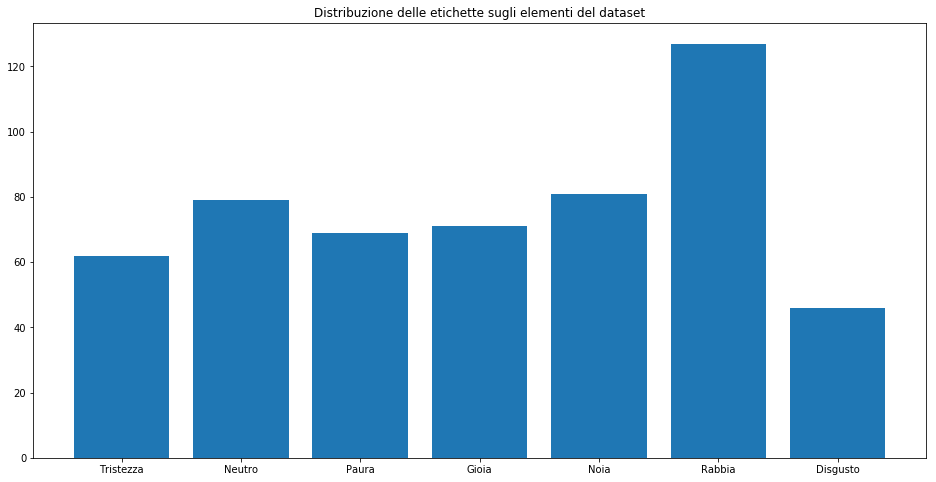

In [5]:
%matplotlib inline

labels = set(features['emotion'])
count = [[label,list(features['emotion']).count(label)] for label in labels]
dict_count = dict(count)

import matplotlib.pyplot as plt

fig = plt.gcf()
plt.title("Distribuzione delle etichette sugli elementi del dataset"), fig.set_size_inches(16, 8)
plt.bar(range(len(dict_count)), dict_count.values()), plt.xticks(range(len(dict_count)), dict_count.keys())
plt.show()

Splittiamo il dataset in training e test set. Scelgo una cross-validation non stratificata in quanto il mio dataset non rispecchia il mondo reale, poichè è irreale che le persone siano più spesso affette da rabbia che dalle altre emozioni; sarebbe stato accettabile se la classe più rappresentata fosse stata "Neutro".

In [6]:
#-----------------IL seguente blocco di codice serviva a gestire la data augmentation-----------------------
# from sklearn.model_selection import KFold
# import numpy as np

# yLong = features['emotion']
# xLong = features.drop(['name','emotion'], 1)

# featuresShort= features.iloc[::3]
# y = featuresShort['emotion']
# x = featuresShort.drop(['name','emotion'], 1)

# nsplits= 10
# kf = KFold(nsplits, shuffle = True, random_state = 3)
# folds = kf.split(x,y)

# train_data=[]
# train_label=[]
# test_data=[]
# test_label=[]
# for f in folds:
#     train = f[0]*3
#     for i in train:
#         train= np.append(train,i+1)
#         train= np.append(train,i+2)
#     train = np.sort(train)
#     test = f[1]*3
#     train_data.append(np.array(list(xLong.iloc[train]['features'])))
#     train_label.append(np.array(list(yLong.iloc[train])))
#     test_data.append(np.array(list(xLong.iloc[test]['features'])))
#     test_label.append(np.array(list(yLong.iloc[test])))

from sklearn.model_selection import KFold
import numpy as np

y = features['emotion']
x = features.drop(['name','emotion'], 1)

nsplits= 10
kf = KFold(nsplits, shuffle = True, random_state = 3)
folds = kf.split(x,y)

train_data=[]
train_label=[]
test_data=[]
test_label=[]
for f in folds:
    train_data.append(np.array(list(x.iloc[f[0]]['features'])))
    train_label.append(np.array(list(y.iloc[f[0]])))
    test_data.append(np.array(list(x.iloc[f[1]]['features'])))
    test_label.append(np.array(list(y.iloc[f[1]])))

Vediamo quanti files audio abbiamo selezionato per il training e per il test:

In [7]:
print ("Dimensione dei fold di train: " + str(len(train_data[0])) + " elementi")
print ("Dimensione dei fold di test: " + str(len(test_data[0])) + " elementi")

Dimensione dei fold di train: 481 elementi
Dimensione dei fold di test: 54 elementi


Usiamo KNN con K tra $1$ e $50$ e vediamo cosa succede:

In [8]:
from sklearn.metrics import zero_one_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

number_of_classifiers = 50

def knnClassify(number_of_classifiers,train_data,train_label,test_data,test_label):
    k_s = range(1, number_of_classifiers + 1)
    knn_classifiers = [KNeighborsClassifier(n_neighbors = k, n_jobs = -1) for k in k_s]
    training_errors = list(range(1, number_of_classifiers + 1))
    test_errors = list(range(1, number_of_classifiers + 1))
    k_accuracy = np.zeros(number_of_classifiers)

    for i in range(0, number_of_classifiers):
        print(i)
        fold_training_errors = list(range(0,nsplits))
        fold_test_errors= list(range(0,nsplits))
        fold_accuracy= list(range(0,nsplits))
        for fold in range(0,nsplits):
            knn_classifiers[i].fit(train_data[fold], train_label[fold])
            prediction_training = knn_classifiers[i].predict(train_data[fold])
            prediction_test = knn_classifiers[i].predict(test_data[fold])
            fold_accuracy[fold] = metrics.accuracy_score(test_label[fold], prediction_test)
            fold_training_errors[fold] = zero_one_loss(train_label[fold], prediction_training)
            fold_test_errors[fold] = zero_one_loss(test_label[fold], prediction_test)
        k_accuracy[i] = sum(fold_accuracy)/nsplits
        training_errors[i] = sum(fold_training_errors)/nsplits
        test_errors[i] = sum(fold_test_errors)/nsplits
    return training_errors,test_errors,k_accuracy


training_errors, test_errors, k_accuracy= knnClassify(number_of_classifiers,train_data,train_label,test_data,test_label)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Vediamo quale è l'andamento dell'accuracy al variare di $k$

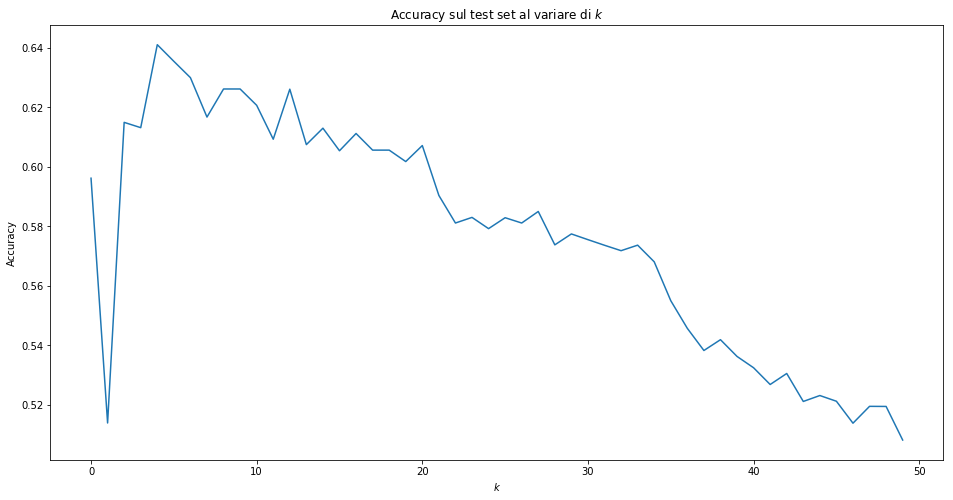

In [9]:
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(k_accuracy)
plt.title("Accuracy sul test set al variare di $k$")
plt.ylabel('Accuracy')
plt.xlabel('$k$')
#plt.xticks(range(1,number_of_classifiers + 1))
plt.show()

Sembra essere più efficace per K molto bassi. KNN non si presta molto bene a numeri sostanziosi di dimensioni, come sappiamo.

In [10]:
print ("Massimo indice del vettore delle accuracy: " + str(k_accuracy.argmax() + 1))

Massimo indice del vettore delle accuracy: 5


Vediamo anche come si comportano training error e test error, supponendo di impiegare una Loss 0-1 e di eseguire uno smoothing:

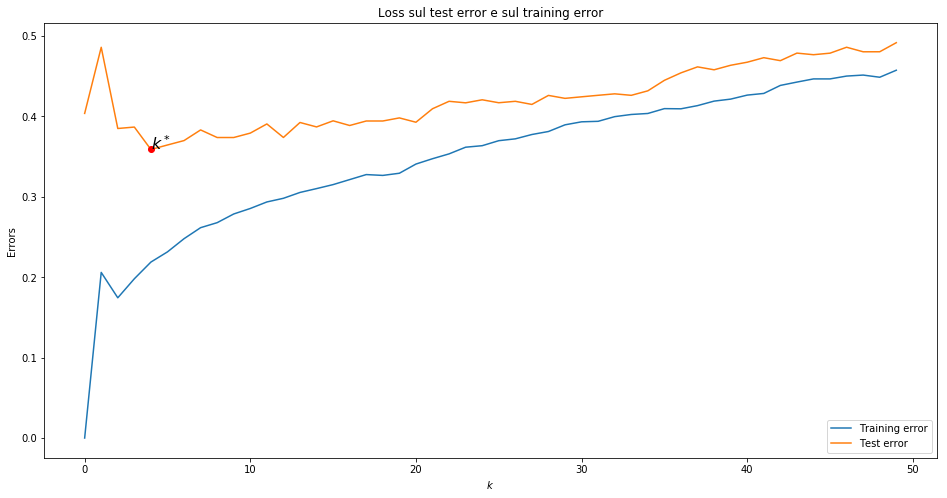

In [11]:
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(training_errors)
plt.plot(test_errors)
plt.legend(['Training error', 'Test error'])
plt.title("Loss sul test error e sul training error")
plt.ylabel('Errors')
plt.xlabel('$k$')
min_test_error_index = test_errors.index(min(test_errors))
min_test_error_value = min(test_errors)
plt.annotate("$k^*$", (min_test_error_index, min_test_error_value), fontsize = 16)
plt.plot([min_test_error_index], [min_test_error_value], 'ro')
#plt.xticks(range(1,number_of_classifiers + 1))
plt.show()

Esplicitiamo il $k^*$, ovvero il $k$ tale per cui è minimo il test error, segue che:

In [12]:
opt_k = test_errors.index(min(test_errors))
print ("Valore ottimo per k: " + str(opt_k + 1))
print ("Minimo errore sul test set: " + str(min_test_error_value))
print ("Massima accuracy sul test set: " + str(k_accuracy.max()))

Valore ottimo per k: 5
Minimo errore sul test set: 0.3589447938504543
Massima accuracy sul test set: 0.6410552061495458


Vediamo in quel caso che risultati abbiamo.

In [13]:
import itertools

def plot_confusion_matrix(cm, classes, normalize = True, 
                          title = 'Matrice di confusione non normalizzata', cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label reale')
    plt.xlabel('Label predetto')

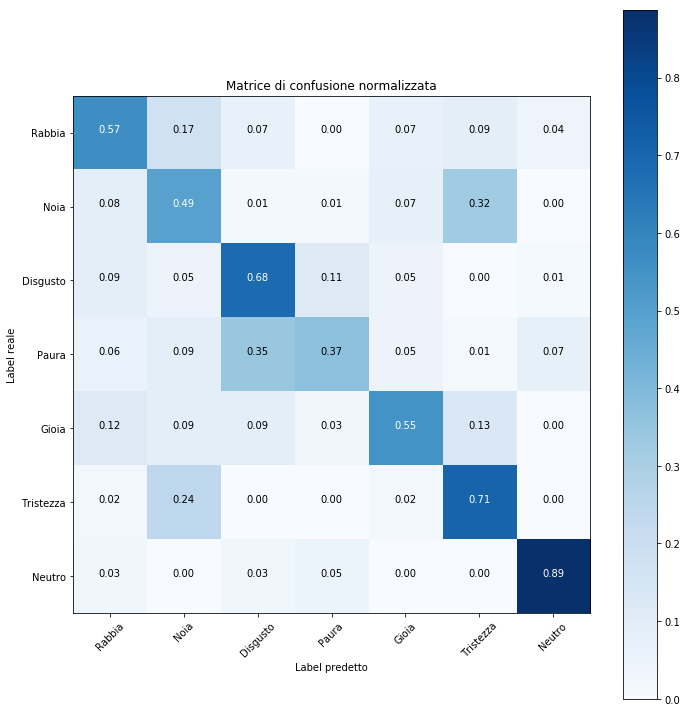

In [14]:
#somma delle matrici di confusione per tutti i dati
knn= KNeighborsClassifier(n_neighbors = opt_k, n_jobs = -1)
Emotions = {'W': "Rabbia", 'L': "Noia", 'E': "Disgusto", 'A': "Paura", 'F' : "Gioia", 'T': "Tristezza", 'N': "Neutro"}
cnf_matrix= np.zeros((len(Emotions),len(Emotions)))
for i in range (0,nsplits):
    knn.fit(train_data[i],train_label[i])
    cnf_matrix = cnf_matrix+metrics.confusion_matrix(test_label[i], knn.predict(test_data[i]))

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes = Emotions.values(), normalize = True,
                      title = 'Matrice di confusione normalizzata')

Per migliorare le performance eseguiamo a questo punto una riduzione di dimensionalità sfruttando la PCA. Prima di eseguirla standardiziamo i dati:

In [15]:
from sklearn.preprocessing import StandardScaler

train_std= []
test_std= []
datatemp= np.concatenate((train_data[0],test_data[0]))
scaler = StandardScaler().fit(datatemp)
for f in range(0,nsplits):
    train_std.append(scaler.transform(train_data[f]))
    test_std.append(scaler.transform(test_data[f])) 

Eseguiamo ora la PCA

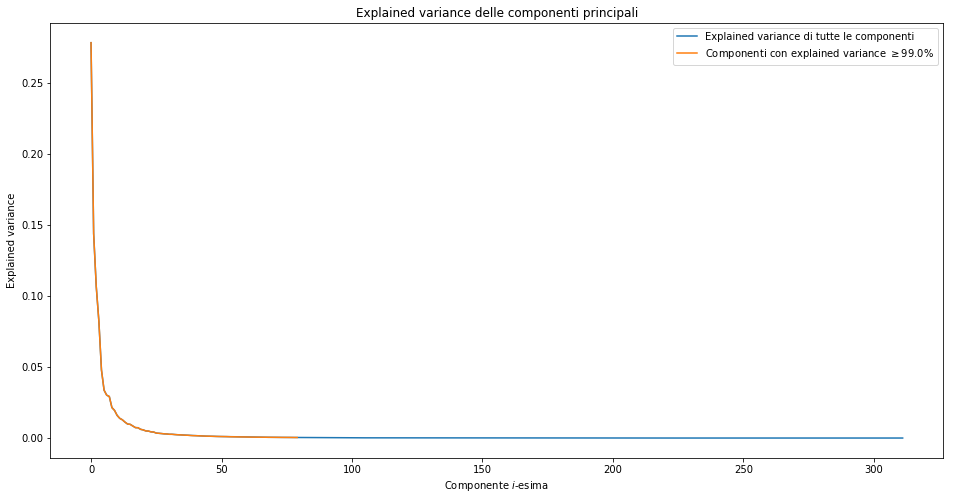

Componenti principali con explained variance totale maggiore o uguale al 99.0% (sono 80):


In [16]:
%matplotlib inline

from sklearn.decomposition import PCA

pca = PCA()
train_pca= []
test_pca= []
pca.fit(datatemp)

plt.figure(figsize = (16, 8))
plt.plot(pca.explained_variance_ratio_) 
tot = 0
varianza_coperta = 0.99 #per Feature locali ho messo 90%, per le feature globali ho messo 99%
grather_than_one=[]
for i in pca.explained_variance_ratio_:
    grather_than_one.append(i)
    tot+=i
    if(tot>=varianza_coperta):
        break

plt.plot(range(len(grather_than_one)), grather_than_one)
plt.legend(['Explained variance di tutte le componenti', 'Componenti con explained variance $\geq ' + str(varianza_coperta*100)+ '$%'])
plt.title("Explained variance delle componenti principali")
plt.xlabel('Componente $i$-esima')
plt.ylabel('Explained variance')
plt.show()
print ("Componenti principali con explained variance totale maggiore o uguale al " +str(varianza_coperta*100)+"% (sono "+ format(len(grather_than_one))+"):")

Impieghiamo ancora K-Nearest Neighbors con $k$ fino a $50$

In [17]:
from sklearn.metrics import zero_one_loss

train_pca=[]
test_pca=[]
pca = PCA(n_components = len(grather_than_one))
pca.fit(datatemp)
for f in range(0,nsplits):
    train_pca.append(pca.transform(train_std[f]))
    test_pca.append(pca.transform(test_std[f]))

number_of_classifiers = 50

training_errors, test_errors, k_accuracy= knnClassify(number_of_classifiers,train_pca,train_label,test_pca,test_label)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


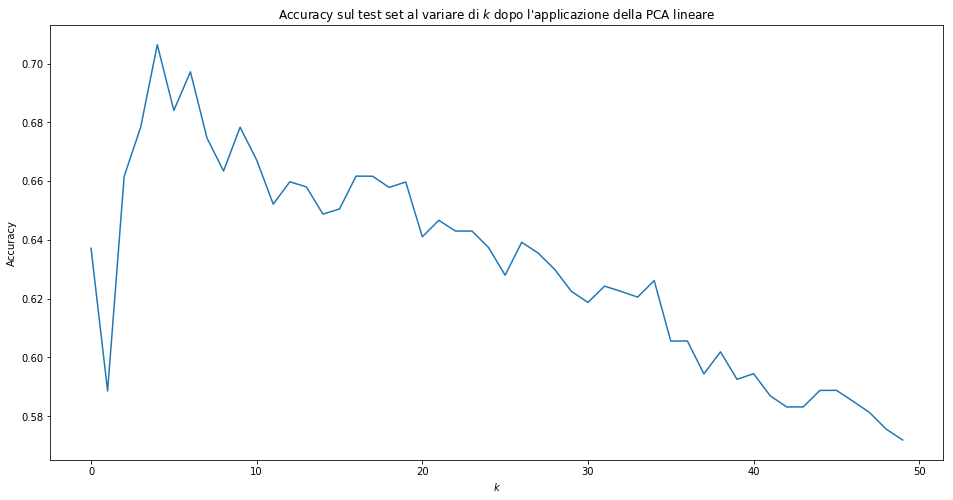

In [18]:
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(k_accuracy)
plt.title("Accuracy sul test set al variare di $k$ dopo l'applicazione della PCA lineare")
plt.ylabel('Accuracy')
plt.xlabel('$k$')
#plt.xticks(range(1,number_of_classifiers + 1))
plt.show()

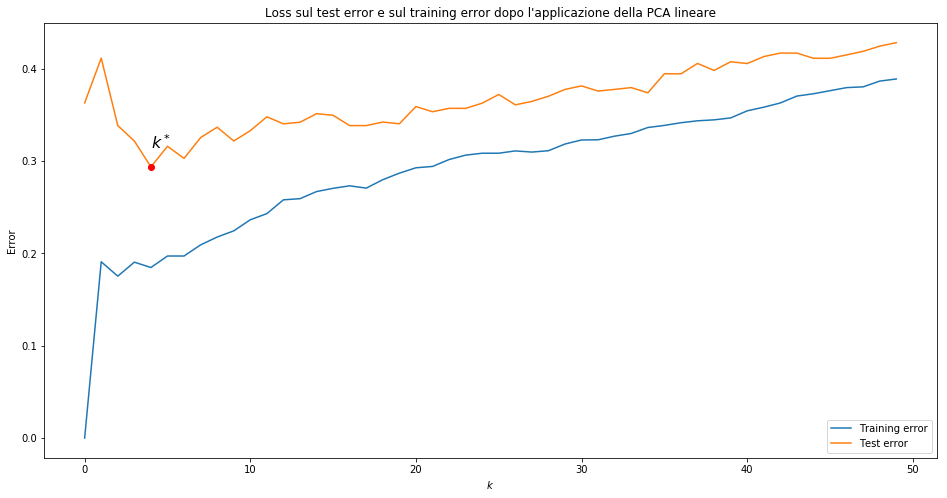

In [19]:
%matplotlib inline

plt.figure(figsize=(16,8))
#N = 20
#smoothed_training_errors = np.convolve(training_errors, np.ones(N)/N, 'same')
#smoothed_test_errors = np.convolve(test_errors, np.ones(N)/N, 'same')
plt.plot(training_errors)
plt.plot(test_errors)
plt.legend(['Training error', 'Test error'])
plt.title("Loss sul test error e sul training error dopo l'applicazione della PCA lineare")
plt.ylabel('Error')
plt.xlabel('$k$')
min_test_error_index = test_errors.index(min(test_errors))
min_test_error_value = min(test_errors)
plt.annotate("$k^*$", (min_test_error_index + 0.02, min_test_error_value + 0.02), fontsize = 16)
plt.plot([min_test_error_index], [min_test_error_value], 'ro')
#plt.xticks(range(1,number_of_classifiers + 1))
plt.show()

In questo modo osserviamo quale massima accuracy otteniamo sul test set e quale errore minimo otteniamo:

In [20]:
print ("Minimo errore sul test set: " + str(min_test_error_value))
print ("Massima accuracy sul test set: " + str(k_accuracy.max()))

Minimo errore sul test set: 0.293570929419986
Massima accuracy sul test set: 0.706429070580014


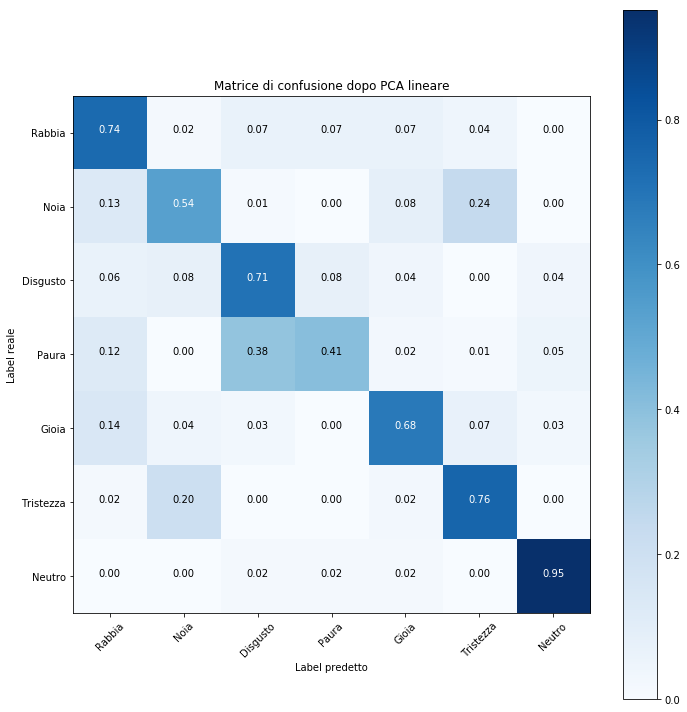

In [21]:
opt_k = test_errors.index(min(test_errors))
Emotions = {'W': "Rabbia", 'L': "Noia", 'E': "Disgusto", 'A': "Paura", 'F' : "Gioia", 'T': "Tristezza", 'N': "Neutro"}
knn= KNeighborsClassifier(n_neighbors = opt_k, n_jobs = -1)
cnf_matrix= np.zeros((len(Emotions),len(Emotions)))
for i in range (0,nsplits):
    knn.fit(train_pca[i],train_label[i])
    cnf_matrix = cnf_matrix+metrics.confusion_matrix(test_label[i], knn.predict(test_pca[i]))

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes = Emotions.values(), normalize = True,
                      title = 'Matrice di confusione dopo PCA lineare')

Abbiamo anche provato a fare PCA con kernel RBF nel corso del progetto, ma si è sempre rivelato estremamente inefficace associato a KNN.

A questo punto proviamo a impiegare Support Vector Machine con kernel lineare.

0
1
2
3
4
5
6
7
8
9
Accuracy sul test set: 0.835325
Loss sul training set: 0.000000
Loss sul test set: 0.164675


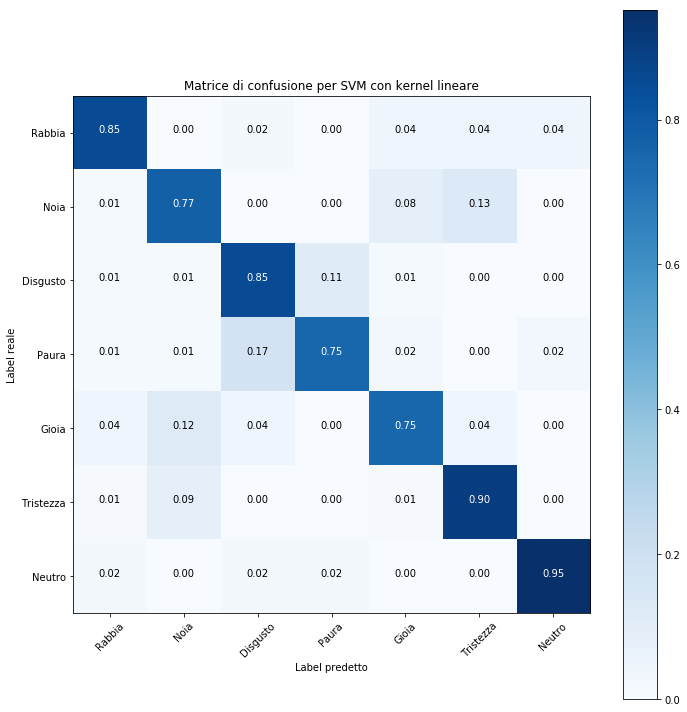

In [22]:
from sklearn.svm import SVC

svm = SVC(kernel = 'linear')
k_accuracy =[]
training_errors= []
test_errors=[]
prediction_test=[]
for f in range (0,nsplits):
    print(f)
    svm.fit(train_std[f], train_label[f])
    prediction_test.append(svm.predict(test_std[f]))
    prediction_training = svm.predict(train_std[f])
    k_accuracy.append(metrics.accuracy_score(test_label[f], prediction_test[f]))
    training_errors.append(zero_one_loss(train_label[f], prediction_training))
    test_errors.append(zero_one_loss(test_label[f], prediction_test[f]))
    
print("Accuracy sul test set: {:f}".format(sum(k_accuracy)/nsplits))
print("Loss sul training set: {:f}".format(sum(training_errors)/nsplits))
print("Loss sul test set: {:f}".format(sum(test_errors)/nsplits))

cnf_matrix = np.zeros((len(Emotions),len(Emotions)))
for f in range(0, nsplits):
        cnf_matrix = cnf_matrix + metrics.confusion_matrix(test_label[f], prediction_test[f])
plt.figure(figsize = (10, 10))
plot_confusion_matrix(cnf_matrix, classes = Emotions.values(), title = 'Matrice di confusione per SVM con kernel lineare')

Proviamo a impiegare ora una SVM con kernel RBF

Accuracy sul test set: 0.805486
Loss sul training set: 0.021390
Loss sul test set: 0.194514


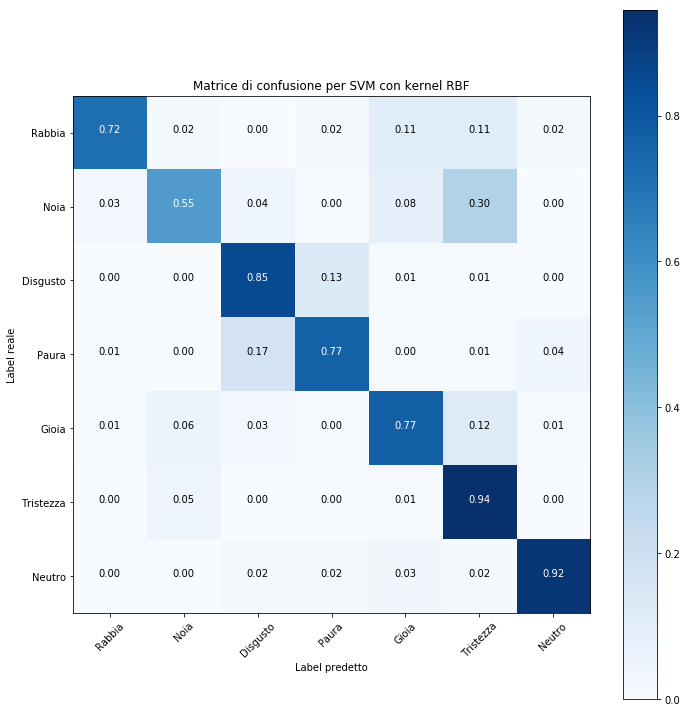

In [23]:
from sklearn.svm import SVC

svm = SVC(kernel = 'rbf')
k_accuracy =[]
training_errors= []
test_errors=[]
prediction_test=[]
for f in range (0,nsplits):
    svm.fit(train_std[f], train_label[f])
    prediction_test.append(svm.predict(test_std[f]))
    prediction_training = svm.predict(train_std[f])
    k_accuracy.append(metrics.accuracy_score(test_label[f], prediction_test[f]))
    training_errors.append(zero_one_loss(train_label[f], prediction_training))
    test_errors.append(zero_one_loss(test_label[f], prediction_test[f]))
    
print("Accuracy sul test set: {:f}".format(sum(k_accuracy)/nsplits))
print("Loss sul training set: {:f}".format(sum(training_errors)/nsplits))
print("Loss sul test set: {:f}".format(sum(test_errors)/nsplits))

cnf_matrix = np.zeros((len(Emotions),len(Emotions)))
for f in range(0, nsplits):
        cnf_matrix = cnf_matrix+metrics.confusion_matrix(test_label[f], prediction_test[f])
plt.figure(figsize = (10, 10))
plot_confusion_matrix(cnf_matrix, classes = Emotions.values(), title = 'Matrice di confusione per SVM con kernel RBF')

Proviamo adesso Gaussian Naive Bayes:

Accuracy sul test set: 0.605625
Loss sul training set: 0.261680
Loss sul test set: 0.394375


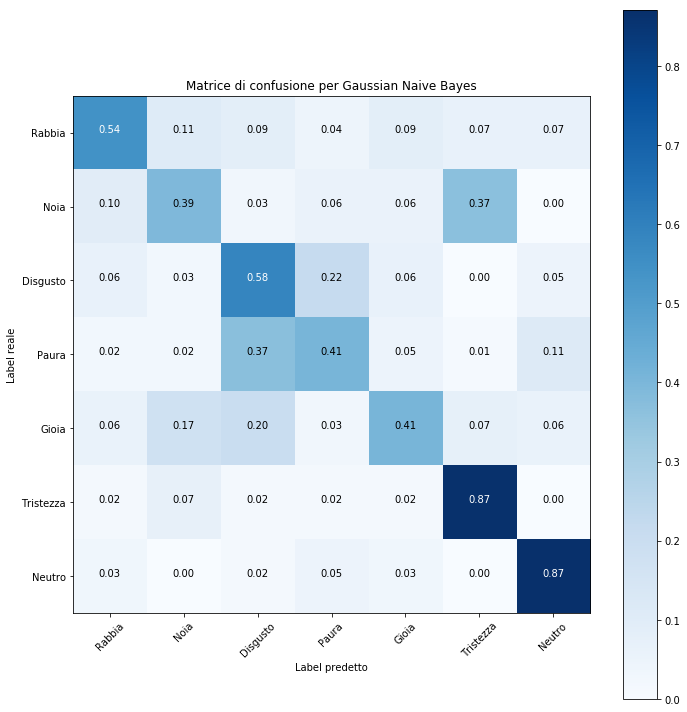

In [24]:
from sklearn.naive_bayes import GaussianNB
gauss_NB = GaussianNB()
k_accuracy =[]
training_errors= []
test_errors=[]
prediction_test=[]
for f in range (0,nsplits):
    gauss_NB.fit(train_data[f], train_label[f])
    prediction_test.append(gauss_NB.predict(test_data[f]))
    prediction_training = gauss_NB.predict(train_data[f])

    k_accuracy.append(metrics.accuracy_score(test_label[f], prediction_test[f]))
    training_errors.append(zero_one_loss(train_label[f], prediction_training))
    test_errors.append(zero_one_loss(test_label[f], prediction_test[f]))
    
print("Accuracy sul test set: {:f}".format(sum(k_accuracy)/nsplits))
print("Loss sul training set: {:f}".format(sum(training_errors)/nsplits))
print("Loss sul test set: {:f}".format(sum(test_errors)/nsplits))

cnf_matrix = np.zeros((len(Emotions),len(Emotions)))
for f in range(0, nsplits):
        cnf_matrix = cnf_matrix+ metrics.confusion_matrix(test_label[f], prediction_test[f])
plt.figure(figsize = (10, 10))
plot_confusion_matrix(cnf_matrix, classes = Emotions.values(), title = 'Matrice di confusione per Gaussian Naive Bayes')